In [1]:
import pickle

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
with open('../data/interim/02_cleaned.pkl', 'rb') as picklefile:
    df_listings = pickle.load(picklefile)

In [3]:
with open('../data/interim/06_topics.pkl', 'rb') as picklefile:
    df_topics = pickle.load(picklefile)

In [4]:
df_listings = df_listings.merge(df_topics, how='left', on=['neighborhood', 'city'])

In [5]:
df_listings = df_listings.dropna().reset_index(drop=True)

#### Create dummy variables

In [6]:
cat_columns = ['host_is_superhost', 'host_response_time', 'cancellation_policy', 'room_type']

In [7]:
df_dummies = df_listings[['neighborhood', 'city', 'reviews_per_month', 'topic', 'bathrooms', 'property_type']]

In [8]:
df_dummies.loc[df_dummies['bathrooms'] <= 1, 'bathrooms'] = 0
df_dummies.loc[df_dummies['bathrooms'] > 1, 'bathrooms'] = 1
df_dummies.rename(columns={'bathrooms': 'multiple_bathrooms'}, inplace=True)

/Users/evaward/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/evaward/anaconda/lib/python2.7/site-packages/pandas/core/frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [9]:
conventional = ['Apartment', 'House', 'Condominium', 'Loft', 'Townhouse']
professional = ['Bed & Breakfast', 'Hostel', 'Boutique Hotel']

In [10]:
df_dummies.loc[:, 'property_cat'] = df_dummies['property_type'].apply(lambda x: 'conventional' if x in conventional else ('professional' if x in professional else 'quirky'))
df_temp = pd.get_dummies(df_dummies['property_cat'], drop_first=True)
df_dummies = df_dummies.merge(df_temp, left_index=True, right_index=True)
df_dummies.drop(['property_type', 'property_cat'], axis=1, inplace=True)

/Users/evaward/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


In [11]:
df_dummies.head()

,neighborhood,city,reviews_per_month,topic,multiple_bathrooms,professional,quirky
0,Brentwood,austin,0.17,2.0,0.0,0.0,0.0
1,Rosedale,austin,0.31,0.0,1.0,1.0,0.0
2,Rosedale,austin,0.46,0.0,0.0,0.0,0.0
3,Rosedale,austin,4.29,0.0,0.0,0.0,0.0
4,Rosedale,austin,3.30,0.0,0.0,0.0,0.0


In [12]:
for column in cat_columns:
    df_temp = pd.get_dummies(df_listings[column], drop_first=True, prefix=column)
    df_dummies = df_dummies.merge(df_temp, left_index=True, right_index=True)

In [13]:
df_dummies.head()

,neighborhood,city,reviews_per_month,topic,multiple_bathrooms,professional,quirky,host_is_superhost_t,host_response_time_no response,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,cancellation_policy_moderate,cancellation_policy_no_refunds,cancellation_policy_strict,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60,room_type_Private room,room_type_Shared room
0,Brentwood,austin,0.17,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Rosedale,austin,0.31,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,Rosedale,austin,0.46,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,Rosedale,austin,4.29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Rosedale,austin,3.30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


#### Standardize numerical features

In [14]:
numerical_columns = ['price_person', 'review_scores_rating']

In [15]:
scale = StandardScaler()
df_num = pd.DataFrame(scale.fit_transform(df_listings[numerical_columns]))
df_num.columns = numerical_columns

#### Merge dataframes

In [16]:
df_model = df_dummies.merge(df_num, left_index=True, right_index=True)

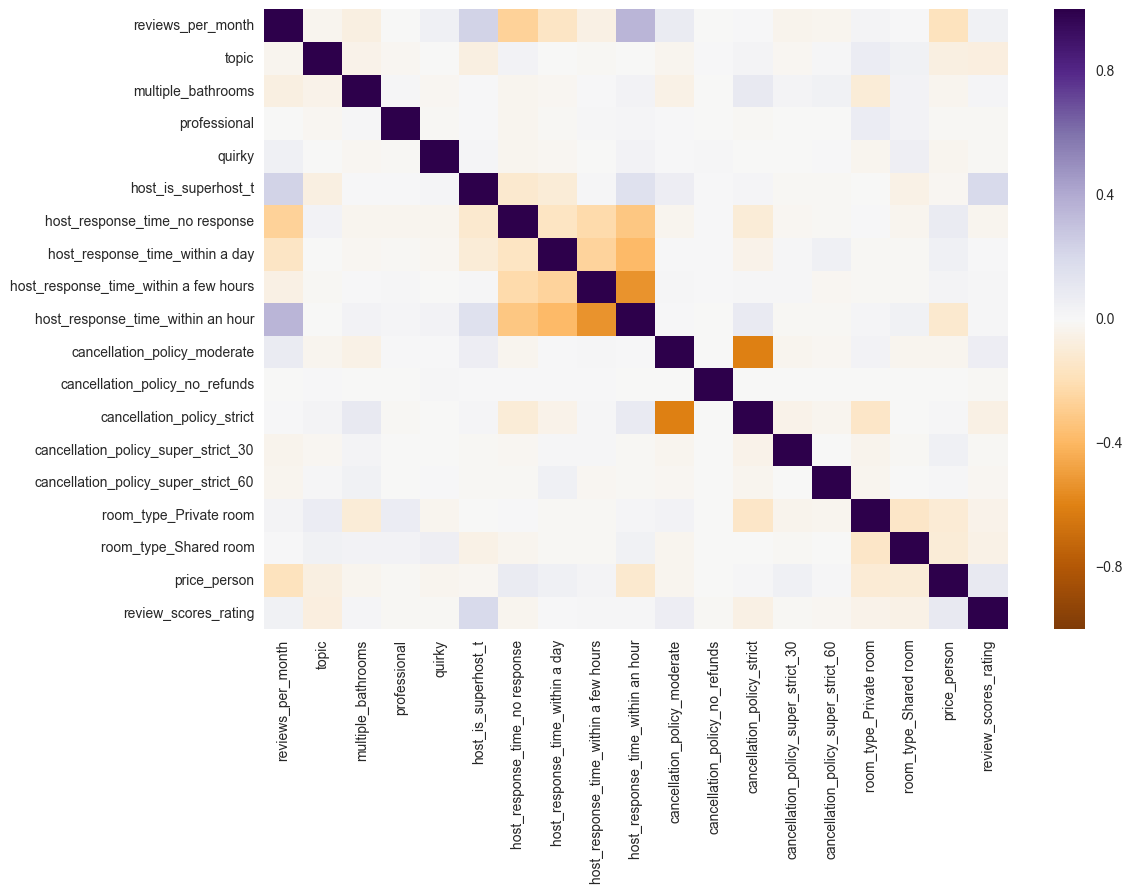

In [17]:
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(df_model.corr(), ax=ax, cmap="PuOr");

In [18]:
X = df_model.drop(['neighborhood', 'city', 'topic'], axis=1)
y = X.pop('reviews_per_month')

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=16)

In [20]:
lr = LinearRegression()

In [21]:
lr.fit(X_train, y_train)
lr.score(X_train, y_train)

0.21431486743883266

In [22]:
lr.score(X_test, y_test)

0.21275227036328792

In [23]:
features = X.columns.tolist()
coefficients = lr.coef_.tolist()
zip(features, coefficients)

[('multiple_bathrooms', -0.3182836884248868),
 ('professional', -0.23401737624046381),
 ('quirky', 0.2522488441408669),
 ('host_is_superhost_t', 0.7554216471778388),
 ('host_response_time_no response', -0.34295113287183115),
 ('host_response_time_within a day', 0.28190319318673784),
 ('host_response_time_within a few hours', 0.6418145996324803),
 ('host_response_time_within an hour', 1.432159476643648),
 ('cancellation_policy_moderate', 0.21981749529567507),
 ('cancellation_policy_no_refunds', -0.5003734284310323),
 ('cancellation_policy_strict', 0.012237482241804098),
 ('cancellation_policy_super_strict_30', -0.8602132966870928),
 ('cancellation_policy_super_strict_60', -0.8544479446209612),
 ('room_type_Private room', 0.016066827279360818),
 ('room_type_Shared room', -0.14072937989845272),
 ('price_person', -0.23434831936429368),
 ('review_scores_rating', 0.018872131379960327)]

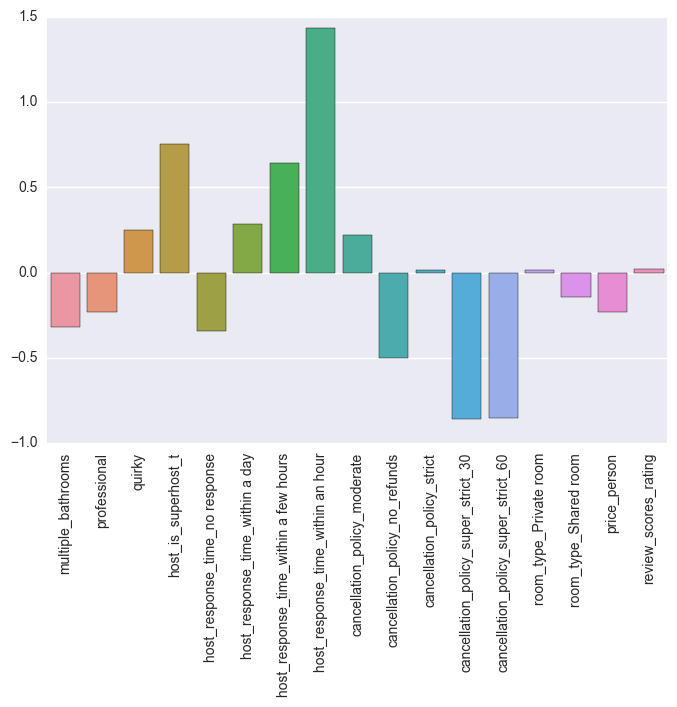

In [24]:
fig = sns.barplot(features, coefficients)
plt.xticks(rotation=90);

### Hyperlocal models

In [31]:
clusters = df_model['topic'].unique().tolist()
clusters.sort()

In [67]:
#keep features to plot coefficients across clusters
from collections import defaultdict
coef_values = dict.fromkeys(features)
for key in coef_values.keys():
    coef_values[key] = []

In [70]:
from sklearn.metrics import mean_squared_error
import numpy as np

In [71]:
def plot_hyperlocals(cluster):
    X_temp = df_model[df_model['topic'] == cluster].drop(['neighborhood', 'city', 'topic'], axis=1)
    y_temp = X_temp.pop('reviews_per_month')
    X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=0.3, random_state=16)
    lr.fit(X_train, y_train)
    
    y_pred = lr.predict(X_test)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    title = 'Cluster ' + str(cluster) + ', # listings: ' + str(len(y_temp)) + ', RMSE: ' + str(score)
    
    #score = lr.score(X_test, y_test)
    #title = 'Cluster ' + str(cluster) + ', # listings: ' + str(len(y_temp)) + ', r^2: ' + str(score)
    
    features = X_temp.columns.tolist()
    coefficients = lr.coef_.tolist()
    
    for feature, coefficient in zip(features, coefficients):
        coef_values[feature].append(coefficient)

    fig, ax = plt.subplots()
    fig = sns.barplot(features, coefficients)
    #ax.set_ybound(lower=0, upper=0.5)
    fig.axes.set_title(title)
    plt.xticks(rotation=90);

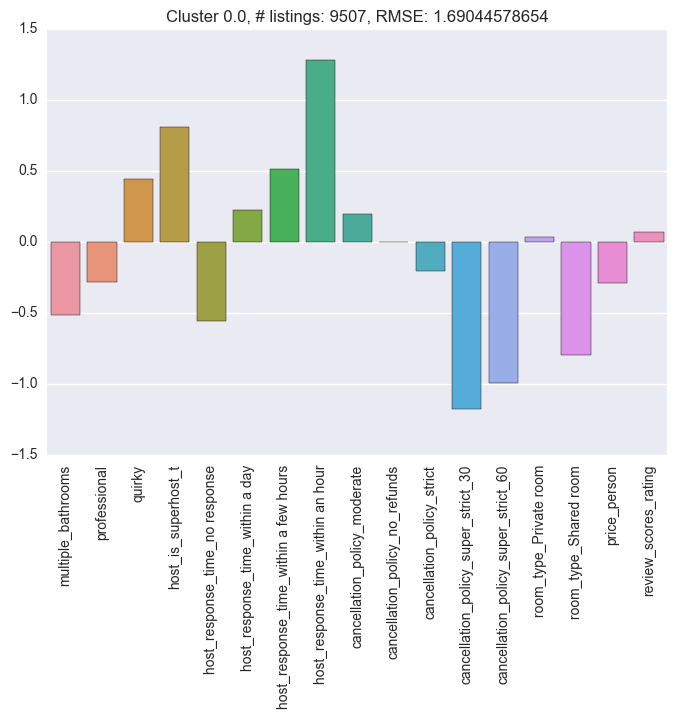

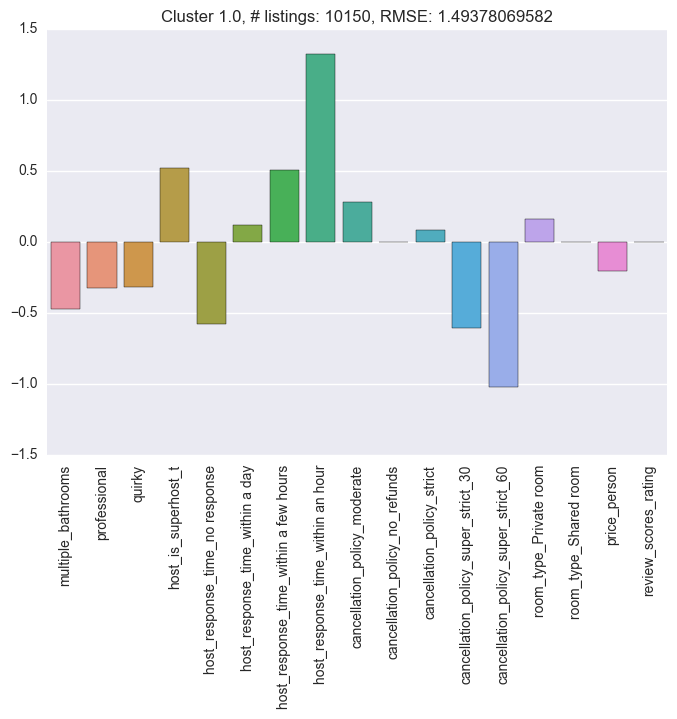

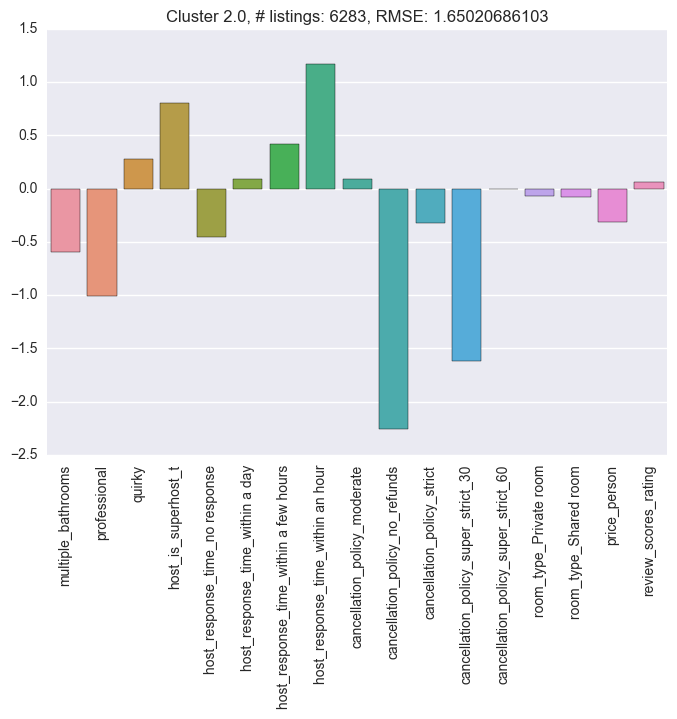

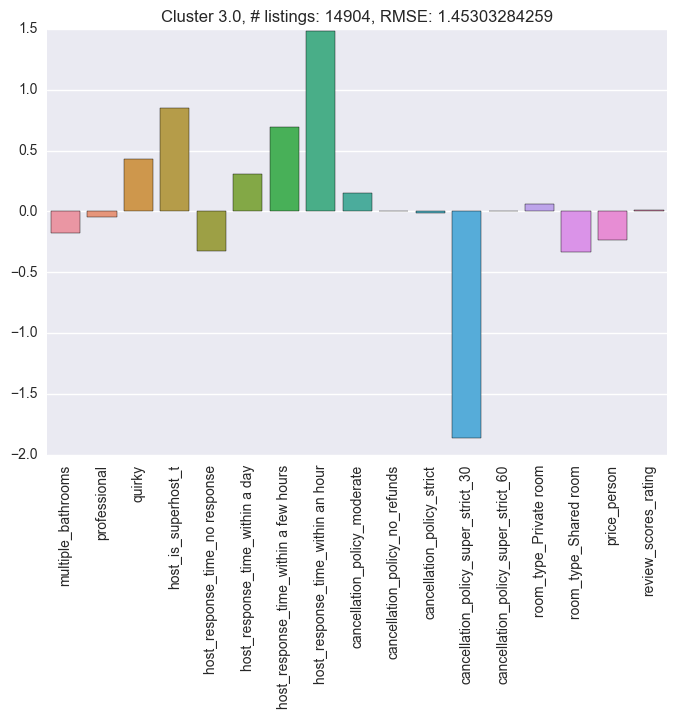

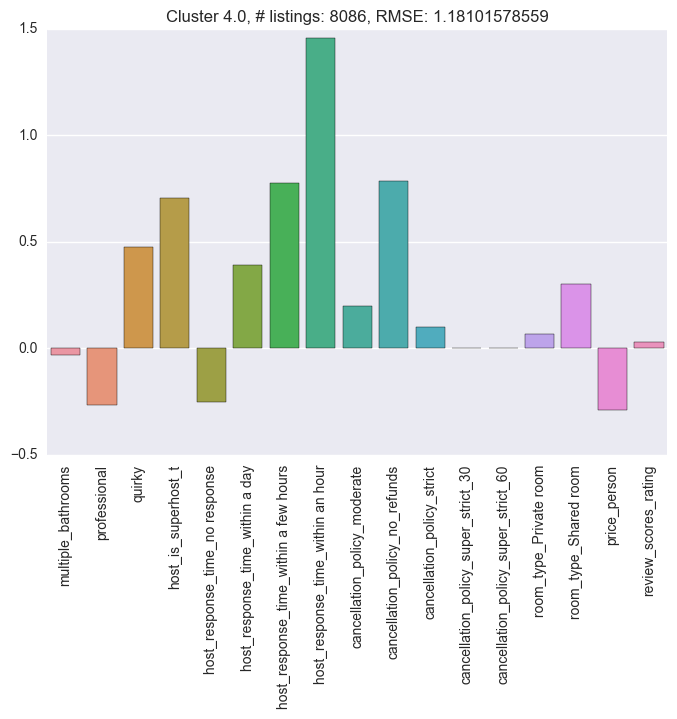

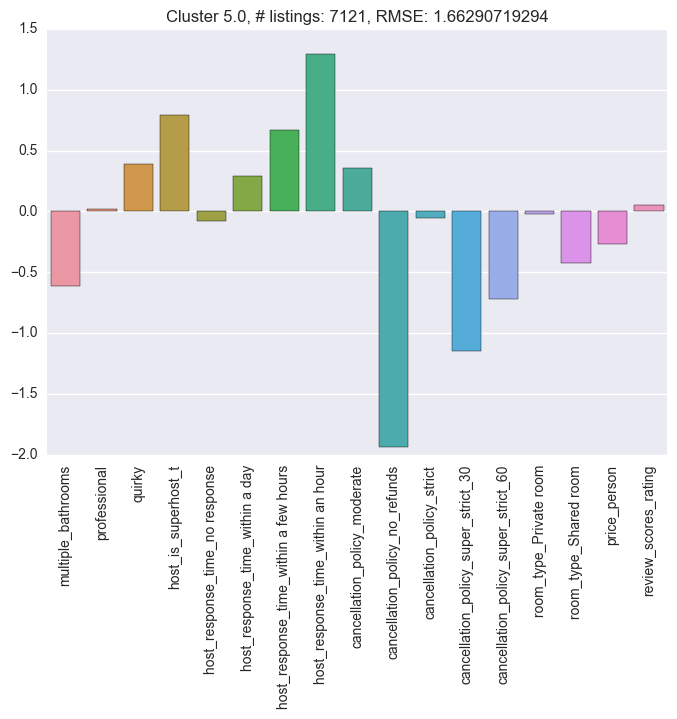

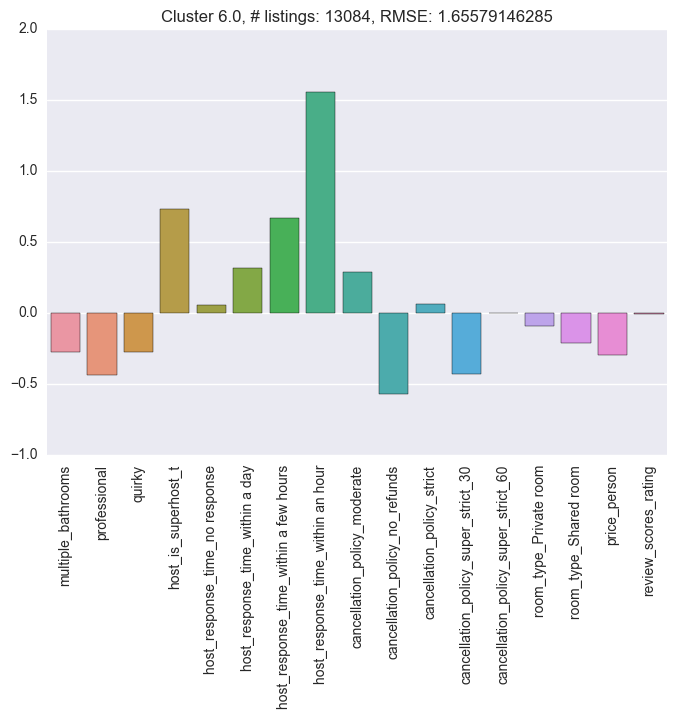

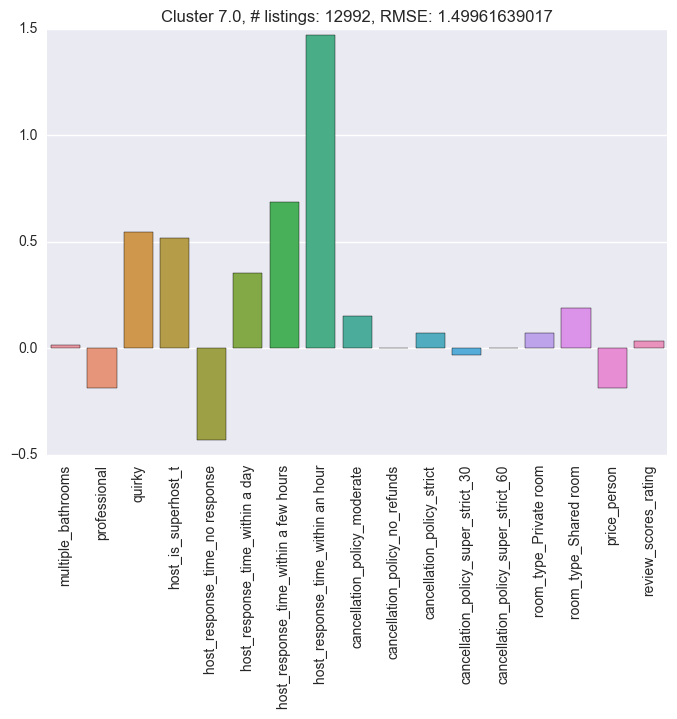

In [72]:
for cluster in clusters:
    plot_hyperlocals(cluster)

In [65]:
def plot_coefficients(dct, key):
    clusters = range(0,8)
    coefficients = dct[key]    
    fig, ax = plt.subplots()
    fig = sns.barplot(clusters, coefficients)
    #ax.set_ybound(lower=0, upper=0.5)
    fig.axes.set_title(key)
    plt.xticks(rotation=90);

In [73]:
coef_values['cancellation_policy_moderate']

[0.19416791525536375,
 0.28368568414386586,
 0.09156401062497743,
 0.1542477514521109,
 0.19898275965504686,
 0.35414351651234743,
 0.29002880822840177,
 0.15248297105337089]

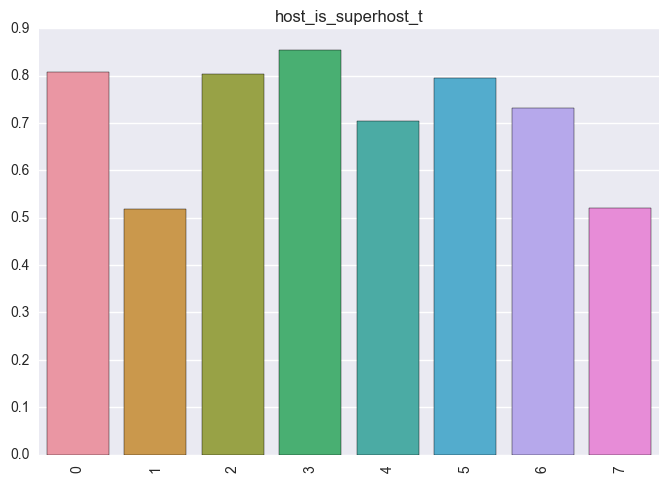

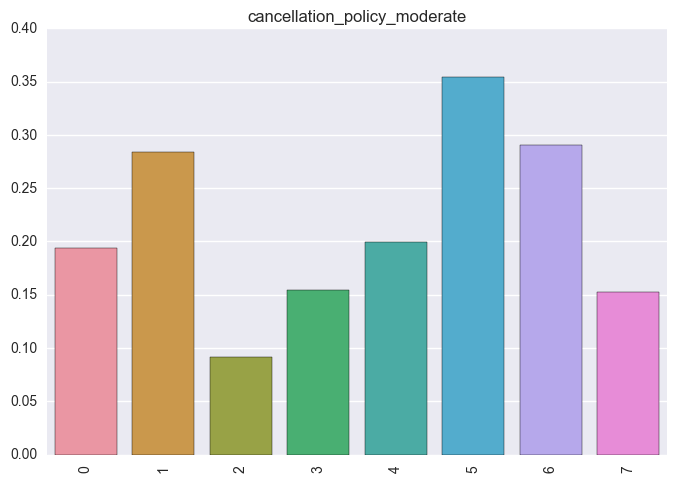

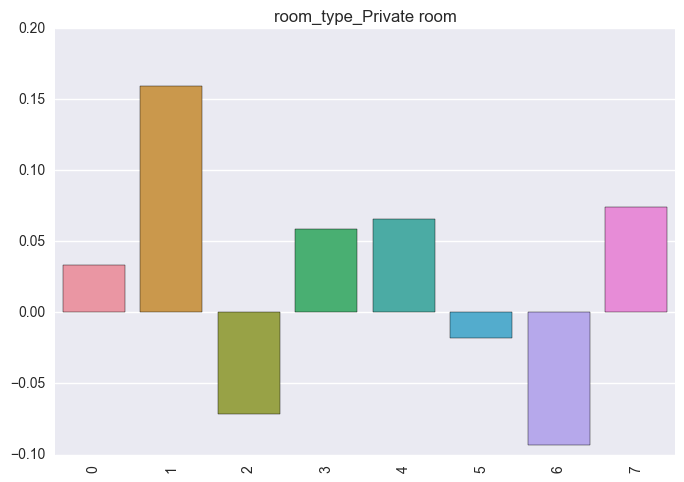

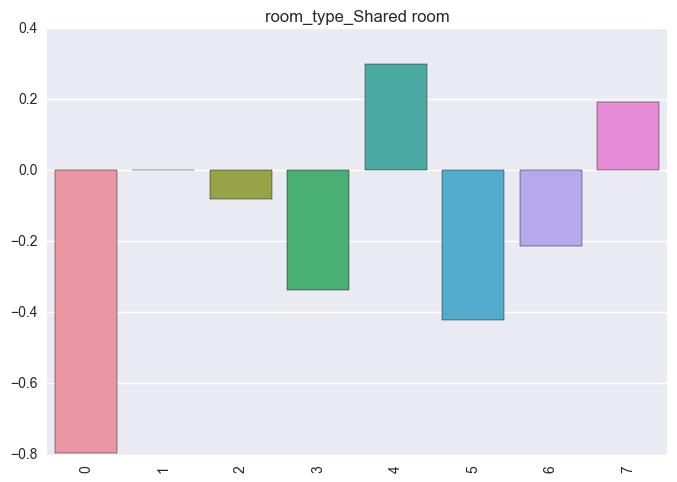

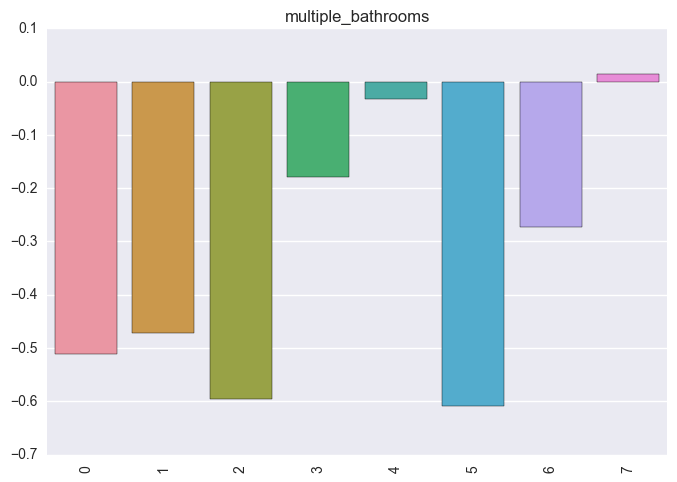

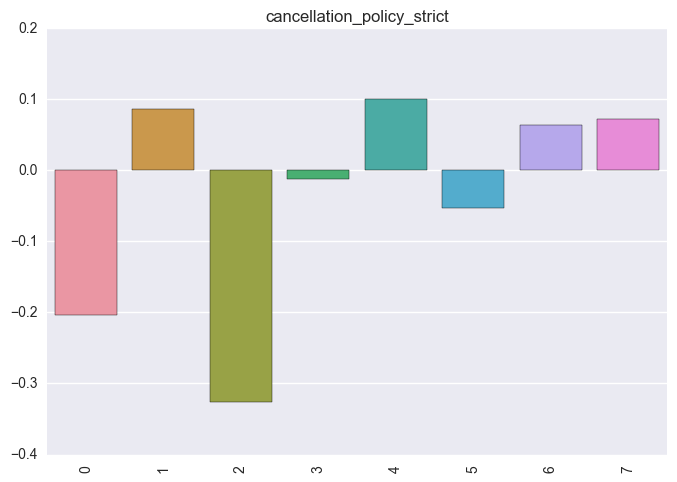

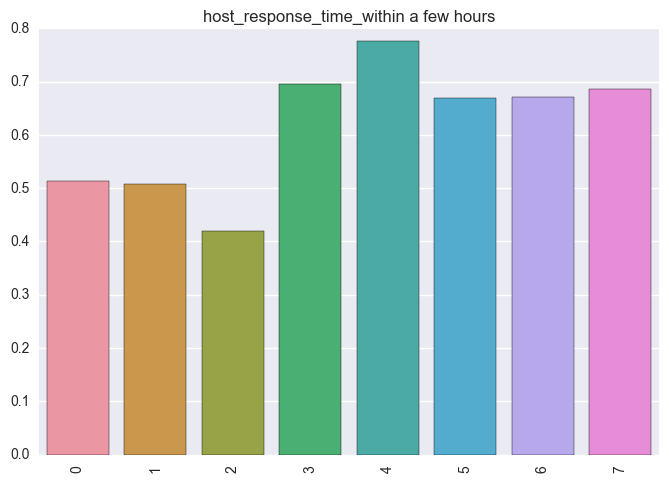

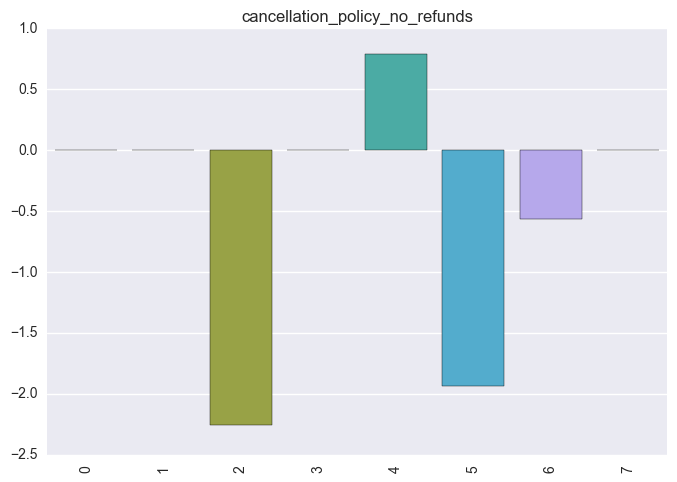

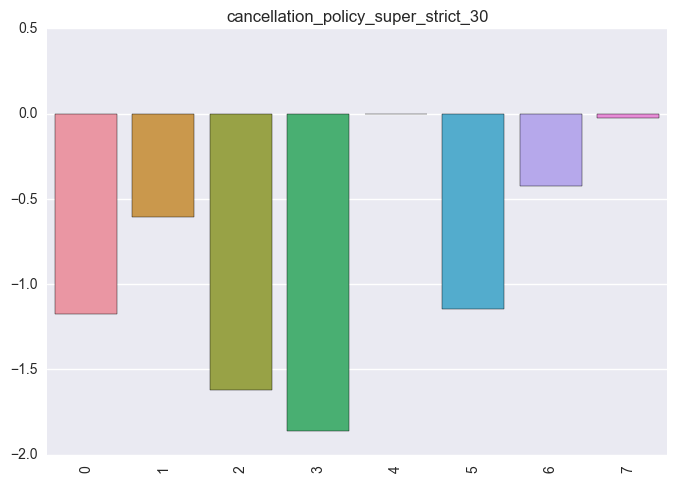

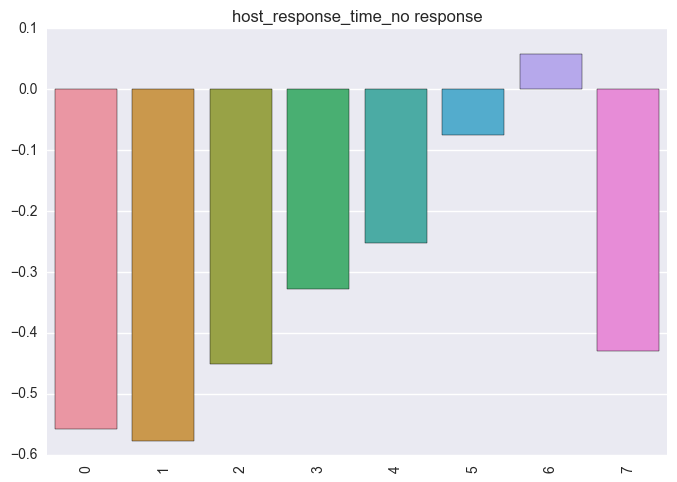

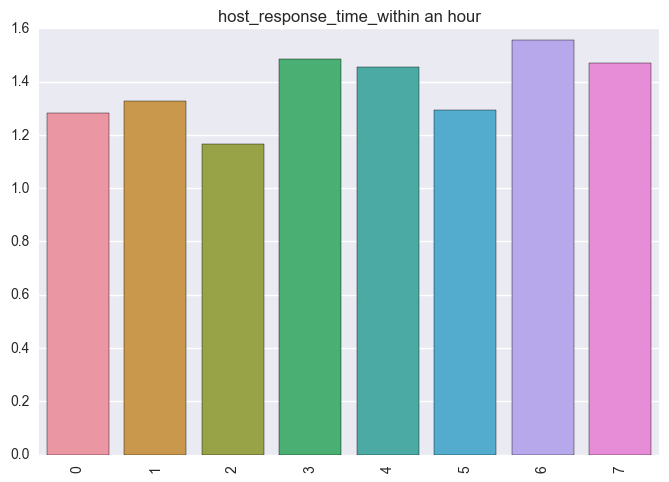

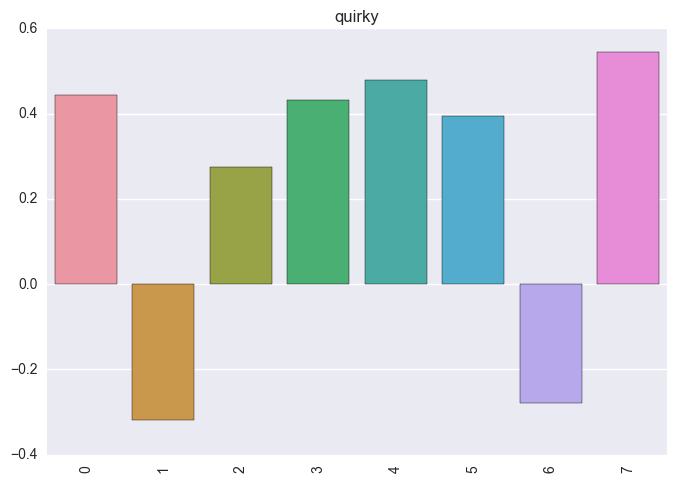

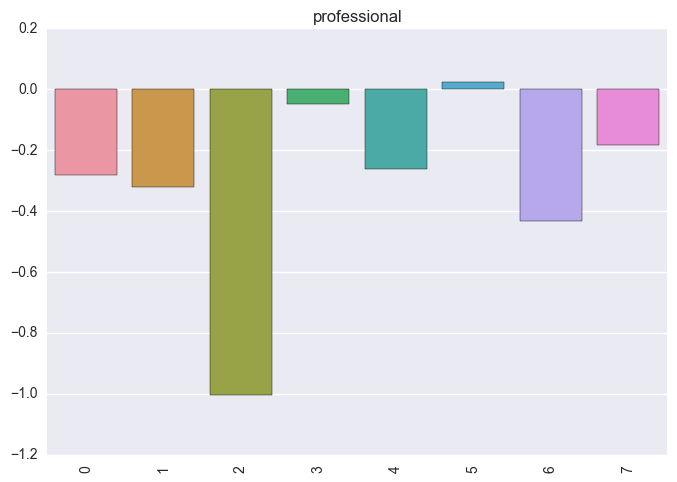

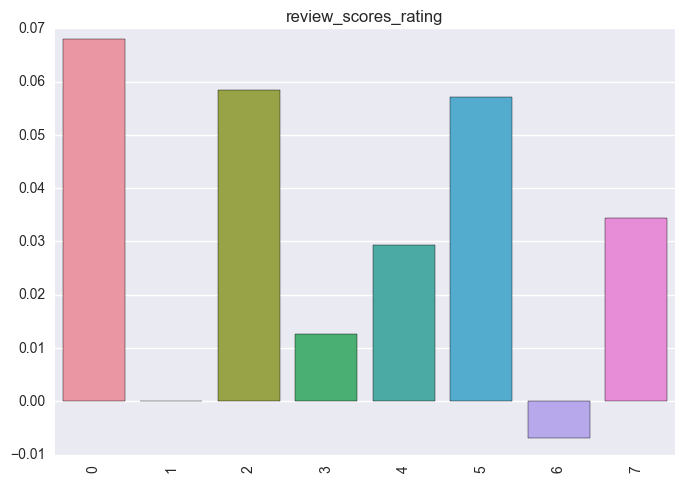

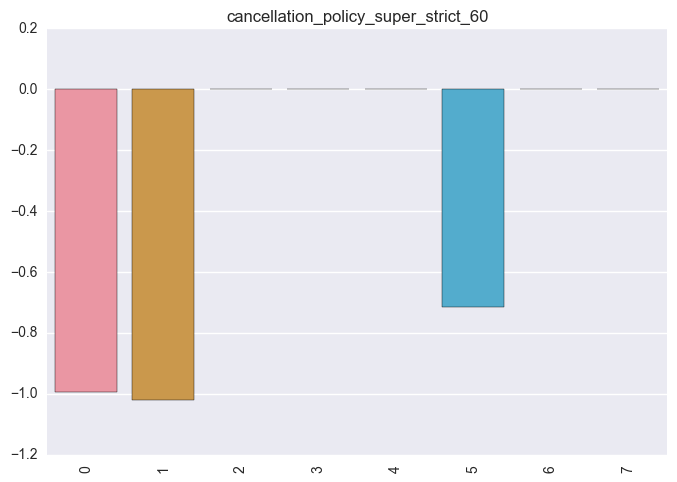

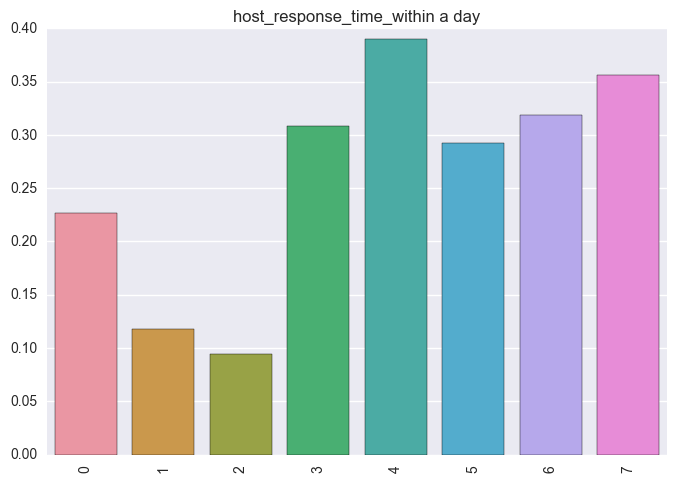

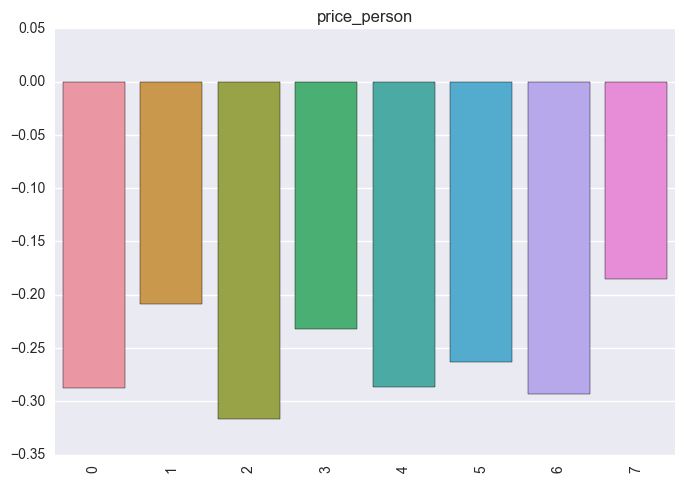

In [66]:
for coefficient in coef_values.keys():
    plot_coefficients(coef_values, coefficient)